## Import required packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas_ta as ta
from dateutil import relativedelta
import warnings
warnings.filterwarnings('ignore')

## Download stock data and check null / missing values

In [2]:
data = yf.download(tickers='INFY.NS', start='2019-01-01', end='2024-03-01')

[*********************100%%**********************]  1 of 1 completed


In [3]:
print(data.isnull().sum())
print(data.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Feature Engineering

### 1. Compute Technical Indicators

In [4]:
data['SMA_50'] = data.ta.sma(length=50)
data['SMA_200'] = data.ta.sma(length=200)
data['RSI'] = data.ta.rsi(length=14)
data['Low_BB'] = data.ta.bbands(length=20).iloc[:,0]
data['Mid_BB'] = data.ta.bbands(length=20).iloc[:,1]
data['High_BB'] = data.ta.bbands(length=20).iloc[:,2]
data['ATR'] = data.ta.atr(length=14)
data['MACD'] = data.ta.macd(length=14).iloc[:,0]
data['VWAP'] = data.ta.vwap()
data['Supertrend'] = data.ta.supertrend(period=50).iloc[:,0]
data.dropna(inplace=True)

### 2. Drop null values and filter data from Jan 2020 to present

In [5]:
data = data.loc['2020-01-01':,:]

### 3. Compute and plot correlation matrix to understand correlation between features

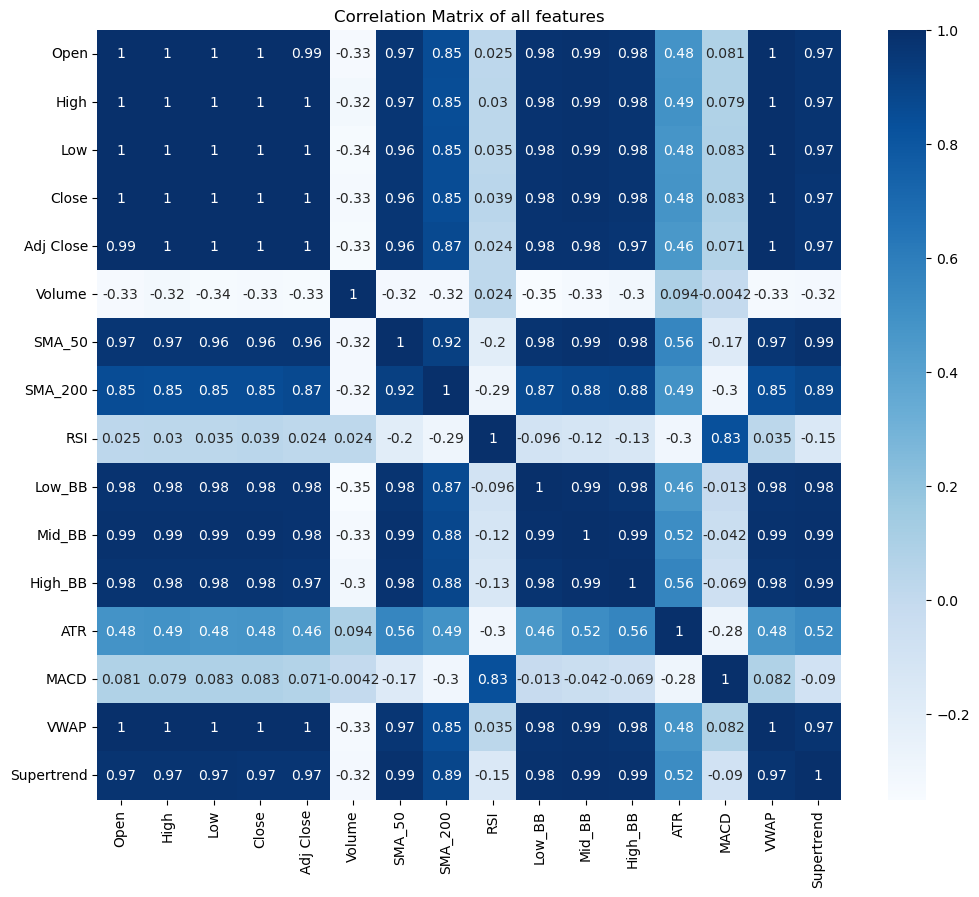

In [6]:
corr_matrix = data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(data=corr_matrix, cmap='Blues', annot=True)
plt.title('Correlation Matrix of all features')
plt.show()

### 4. Drop features with highest correlations

In [7]:
data.drop(columns=['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)

### 5. Compute VIF and drop features with high VIF

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = data[['Volume', 'SMA_50', 'SMA_200', 'Low_BB', 'Mid_BB', 'High_BB', 'RSI', 
                         'MACD', 'ATR', 'VWAP', 'Supertrend']]

vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)


       Feature          VIF
0       Volume     3.853414
1       SMA_50  6495.238362
2      SMA_200   124.824917
3       Low_BB          inf
4       Mid_BB          inf
5      High_BB          inf
6          RSI    28.533517
7         MACD    18.641321
8          ATR    35.486648
9         VWAP  5551.180483
10  Supertrend  1278.547515


In [9]:
data.drop(columns=['SMA_50', 'Mid_BB', 'Low_BB', 'High_BB', 'VWAP', 'Supertrend'], 
          axis=1, inplace=True)

In [10]:
features = data[['Volume', 'SMA_200', 'RSI', 'MACD', 'ATR']]

vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)


   Feature        VIF
0   Volume   3.604805
1  SMA_200  22.565680
2      RSI  21.016912
3     MACD   2.456362
4      ATR  22.312808


## Build models

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *

results = {}

#### Create a column as Predicted with next day's close price

In [12]:
data['Predicted'] = data['Close'].shift(-1)
data.dropna(inplace=True)

#### Standardize features

In [13]:
features = data[['Volume', 'SMA_200', 'RSI', 'MACD', 'ATR']]
target = data['Predicted']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=data.index)
features_scaled['Close'] = data.loc[:,'Close']

#### Split Train and Test data

In [14]:
last_3_months = features_scaled.index.max() - pd.DateOffset(months=3)
X_train = features_scaled.loc[features_scaled.index <= last_3_months]
X_test = features_scaled.loc[features_scaled.index > last_3_months]
y_train = target.loc[target.index <= last_3_months]
y_test  = target.loc[target.index > last_3_months]

### 1. Linear Regression model
Assumptions of Linear Regression:

- Linearity: The relationship between the independent variables and the dependent variable is linear.
- Independence: The residuals (errors) are independent of each other.
- Homoscedasticity: The variance of the residuals is constant across all levels of the independent variables.
- Normality of Residuals: The residuals are normally distributed.
- No Multicollinearity: The independent variables are not highly correlated with each other.

In [15]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)

results['Linear Regression'] = [mse, r2, mae]

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 713.9375010350286
R^2 Score: 0.8988396804452967
Mean Absolute Error: 18.7405796672219


In [16]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

X_train_sm.index = y_train.index
X_test_sm.index = y_test.index

model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.579e+04
Date:                Wed, 03 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:21:12   Log-Likelihood:                -4380.3
No. Observations:                 970   AIC:                             8775.
Df Residuals:                     963   BIC:                             8809.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9728      8.125     -0.243      0.8

### Plot Actual vs Predicted values by the model

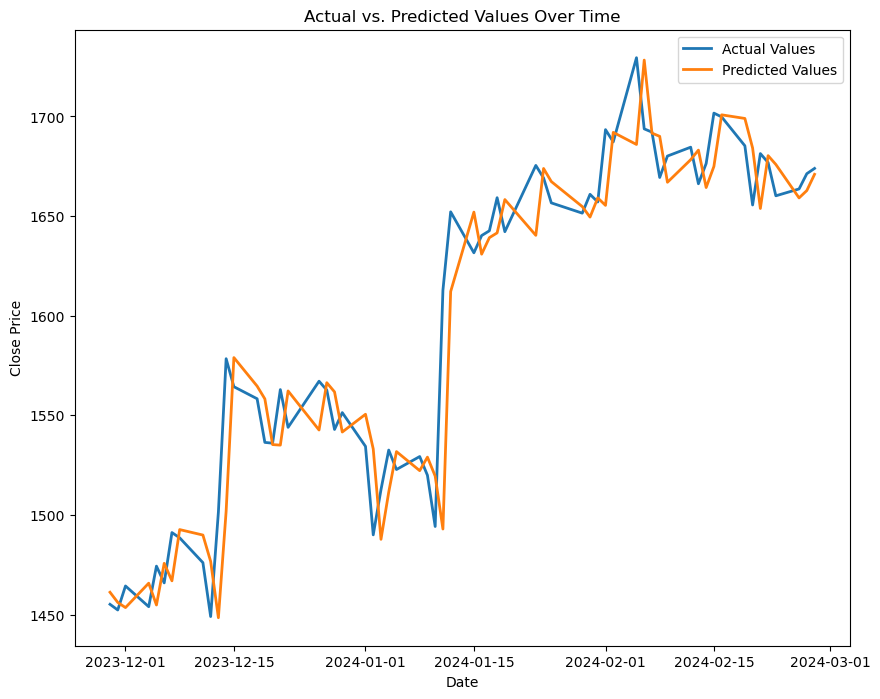

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(y_test.index, y_test, label='Actual Values', linewidth=2)
plt.plot(y_test.index, lr_pred, label='Predicted Values', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.show()


### 2. Random Forest Model
Assumptions of Random Forest
- Independence of Observations: Assumes that each sample is independent of the others. This is generally a requirement for all machine learning models.
- No Need for Linearity: Does not assume a linear relationship between features and the target variable. It can capture complex, non-linear interactions.
- Handling of Missing Values: Can handle missing values inherently. However, preprocessing steps to handle missing values can improve model performance.
- No Multicollinearity Concerns: Not sensitive to multicollinearity. Unlike linear models, correlated features do not adversely affect the performance of the model.
- Feature Importance and Scaling: Can rank features by importance, though it does not require features to be scaled. However, scaling might still be beneficial when using distance-based metrics for splitting nodes.

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)

results['Random Forest'] = [mse, r2, mae]

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 894.4767320967512
R^2 Score: 0.8732584407991275
Mean Absolute Error: 21.395863657149068


In [19]:
rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 13, 25, None],
    'min_samples_split': [3, 8, 15],
    'min_samples_leaf': [1, 3, 7]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_rf = grid_search.best_estimator_
rf_pred_hpt = best_rf.predict(X_test)

mse = mean_squared_error(y_test, rf_pred_hpt)
r2 = r2_score(y_test, rf_pred_hpt)
mae = mean_absolute_error(y_test, rf_pred_hpt)

results['Random Forest HPT'] = [mse, r2, mae]

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 100}
Mean Squared Error: 870.4668986488978
R^2 Score: 0.8766604786813215
Mean Absolute Error: 21.190234980357957


### Plot Actual vs Predicted values

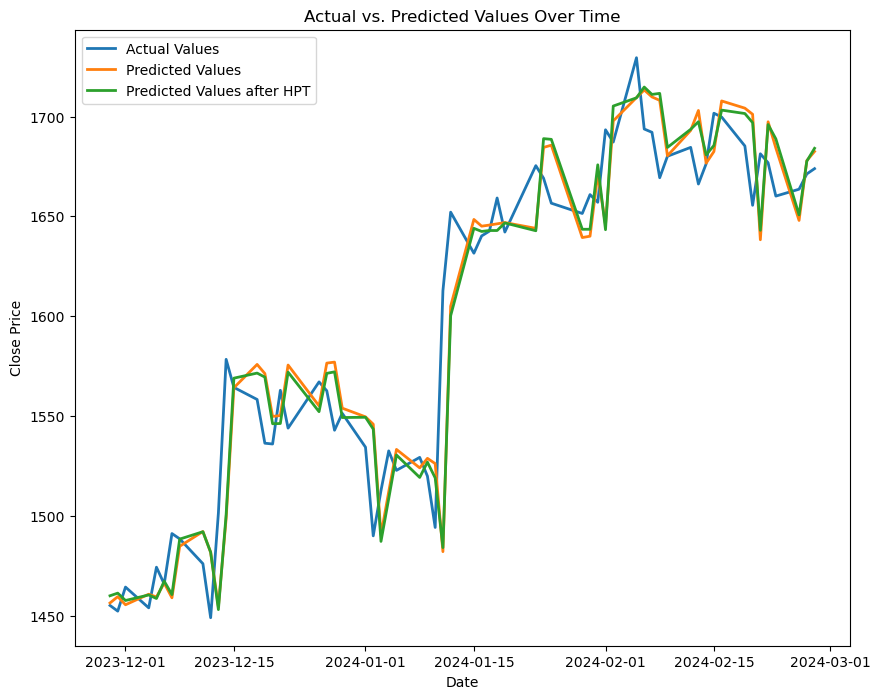

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(y_test.index, y_test, label='Actual Values', linewidth=2)
plt.plot(y_test.index, rf_pred, label='Predicted Values', linewidth=2)
plt.plot(y_test.index, rf_pred_hpt, label='Predicted Values after HPT', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.show()

### 3. Gradient Boosting Model 
Assumptions

- Weak Learners: The algorithm uses a collection of weak learners (usually decision trees) to create a strong learner, thereby minimizing bias and variance.
- Boosting: It is an ensemble learning method where each subsequent model corrects errors made by the previous ones, focusing on hard-to-predict cases.
- No Independence Assumption: Unlike some other algorithms, Gradient Boosting does not assume that the features are independent of each other.
- Robustness: It is robust to outliers and can handle different types of data (numerical, categorical).
- Complexity: The model can be prone to overfitting if not properly tuned, especially with deep trees and high learning rates.

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)

mse = mean_squared_error(y_test, gb_pred)
r2 = r2_score(y_test, gb_pred)
mae = mean_absolute_error(y_test, gb_pred)

results['Gradient Boosting'] = [mse, r2, mae]

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 857.0823686005665
R-squared Score: 0.8785569798944048
Mean Absolute Error: 20.786879275376442


In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
gb_pred_hpt = best_model.predict(X_test)

mse = mean_squared_error(y_test, gb_pred_hpt)
r2 = r2_score(y_test, gb_pred_hpt)
mae = mean_absolute_error(y_test, gb_pred_hpt)

results['Gradient Boosting HPT'] = [mse, r2, mae]

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error: 838.2556033688185
R-squared Score: 0.8812246105823347
Mean Absolute Error: 20.525644843128095


### Plot Acutal vs Predicted values

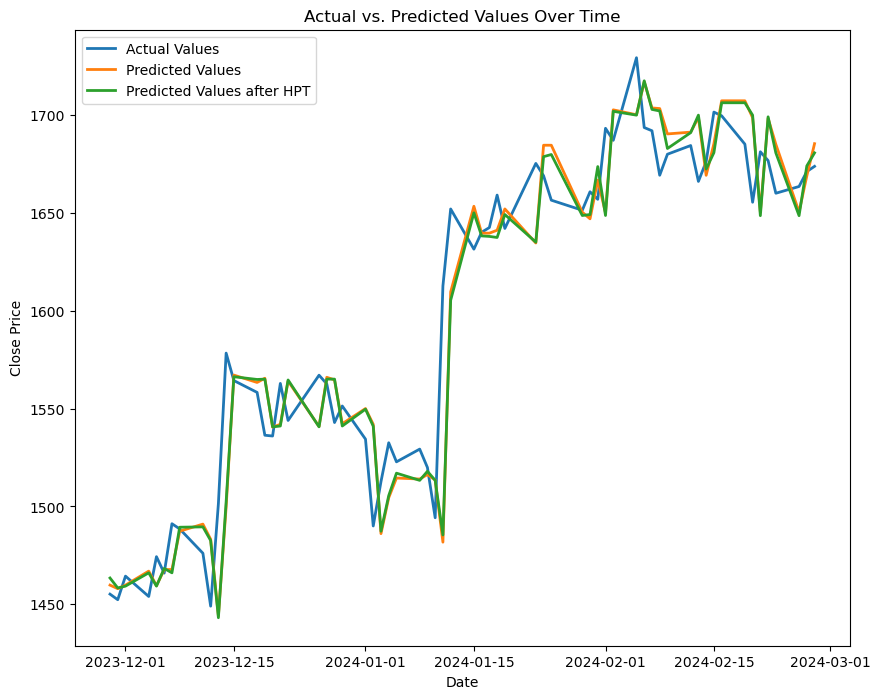

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(y_test.index, y_test, label='Actual Values', linewidth=2)
plt.plot(y_test.index, gb_pred, label='Predicted Values', linewidth=2)
plt.plot(y_test.index, gb_pred_hpt, label='Predicted Values after HPT', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.show()

### 4. Support Vector Machine model
Assumptions

- Linear Separability: SVM assumes that the data is linearly separable, or it can be transformed into a higher-dimensional space where it is linearly separable.
- Kernel Selection: The choice of the kernel and its parameters significantly impacts the model's performance.
- Margin Maximization: SVM aims to find the hyperplane that maximizes the margin between the classes, making it less sensitive to outliers.
- Binary Classification: SVM is inherently a binary classifier, although it can be extended to handle multi-class classification.
- Scalability: While effective for small to medium-sized datasets, SVM can be computationally expensive for large datasets, especially with non-linear kernels.

In [24]:
from sklearn.svm import SVR

svm_model = SVR()

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

mse = mean_squared_error(y_test, svm_pred)
r2 = r2_score(y_test, svm_pred)
mae = mean_absolute_error(y_test, svm_pred)

results['Support Vector Machine'] = [mse, r2, mae]

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 22656.636885098338
R-squared Score: -2.210298694225579
Mean Absolute Error: 135.37133047935373


In [27]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=SVR(),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
svm_pred_hpt = best_model.predict(X_test)

mse = mean_squared_error(y_test, svm_pred_hpt)
r2 = r2_score(y_test, svm_pred_hpt)
mae = mean_absolute_error(y_test, svm_pred_hpt)

results['Support Vector Machine HPT'] = [mse, r2, mae]

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Squared Error: 702.3444579862479
R-squared Score: 0.9004823395544287
Mean Absolute Error: 18.447023345587255


### Plot Actual vs Predicted values

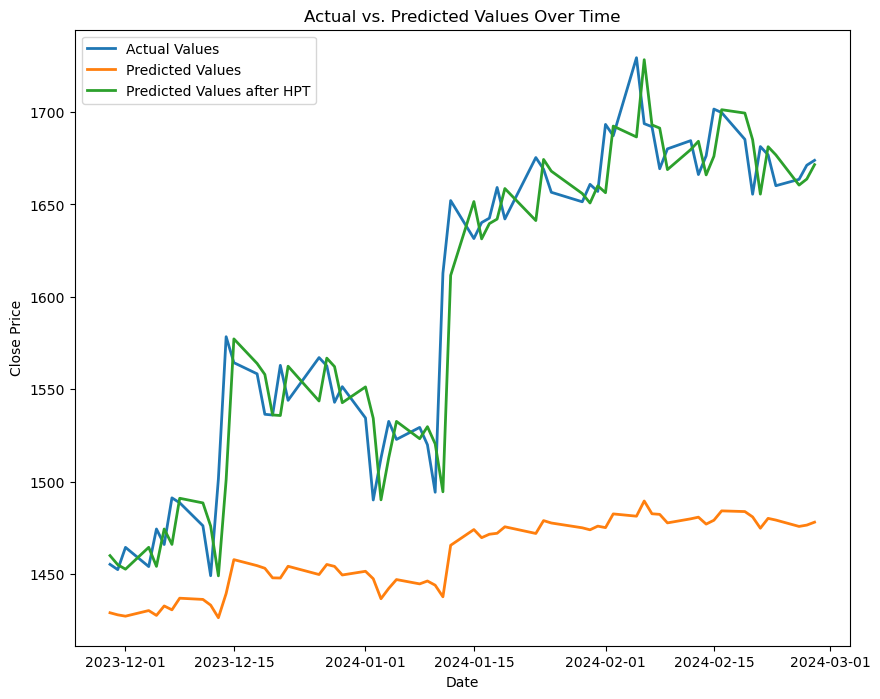

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(y_test.index, y_test, label='Actual Values', linewidth=2)
plt.plot(y_test.index, svm_pred, label='Predicted Values', linewidth=2)
plt.plot(y_test.index, svm_pred_hpt, label='Predicted Values after HPT', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.show()

### Key Observations
####  Baseline Performance:

- Linear Regression showed the best baseline performance with an MSE of 713.94, R² of 0.899, and MAE of 18.74.
- SVR had the worst baseline performance, indicating a need for significant tuning.

#### Hyperparameter Tuning:

- Hyperparameter tuning improved the performance of all models, with SVR showing the most dramatic improvement.
- Post-tuning, SVR achieved an MSE of 702.34 and R² of 0.900, making it the best-performing model in terms of MSE and R².

#### Random Forest and Gradient Boosting:

- Both Random Forest and Gradient Boosting showed slight improvements after tuning, with Gradient Boosting having a lower MSE and higher R² compared to Random Forest.

#### Error Metrics:

- MAE was reduced for all models after tuning, with the most significant reduction seen in SVR.


### Conclusion
After evaluating the models, Support Vector Regression (SVR) with hyperparameter tuning emerged as the best-performing model for predicting Infosys stock prices. Despite its poor baseline performance, the hyperparameter tuning process optimized its parameters to significantly enhance its predictive accuracy, surpassing other models in terms of MSE and R².